# Кластеризация ЕГЭ (4 если сделаны все задачи)

Рядом лежат данные с координатами точек. Везде используется Евклидово расстояние. Кластером считается набор не менее чем из 30 точек связанных друг с другом. Аномалия это точка находящаяся на расстоянии более 1 от любого кластера.

* Постройте Распределение точек
* Напишите руками DBSCAN и обработайте им все файлы
* Файл 0.xls также решите руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Отметьте Аномалии отдельным цветом
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите два числа - Среднее абсцисс и ординат центроидов кластеров * 100000


Файл: 0.xls
Количество кластеров: 2
Количество шумовых точек: 16


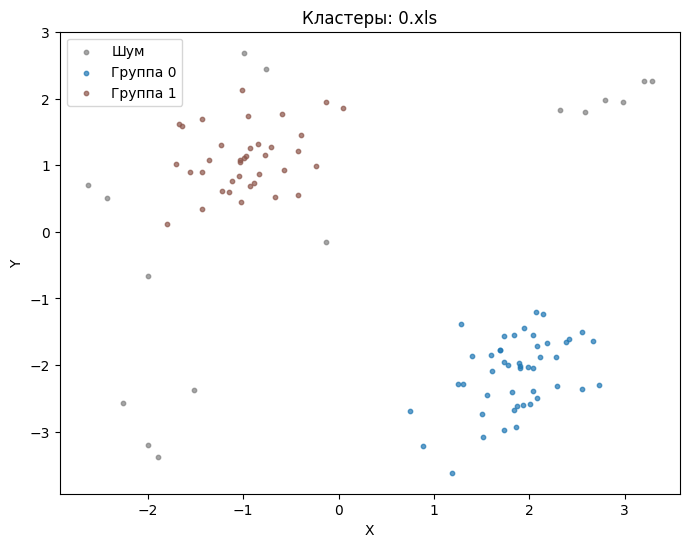

Кластер 0: медоид = [ 1.90546599 -2.04085179]
Кластер 1: медоид = [-0.99483344  1.11411203]
Среднее центроидов * 100000 → X=44399, Y=-51244

Файл: 1.xls
Количество кластеров: 2
Количество шумовых точек: 12


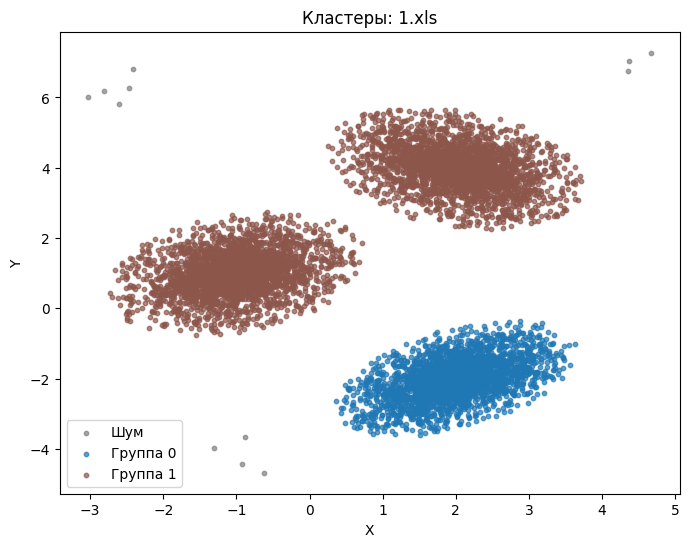

Кластер 0: медоид = [ 1.99791135 -1.99916426]
Кластер 1: медоид = [0.17957678 2.15140837]
Среднее центроидов * 100000 → X=124659, Y=24805

Файл: 2.txt
Количество кластеров: 2
Количество шумовых точек: 55


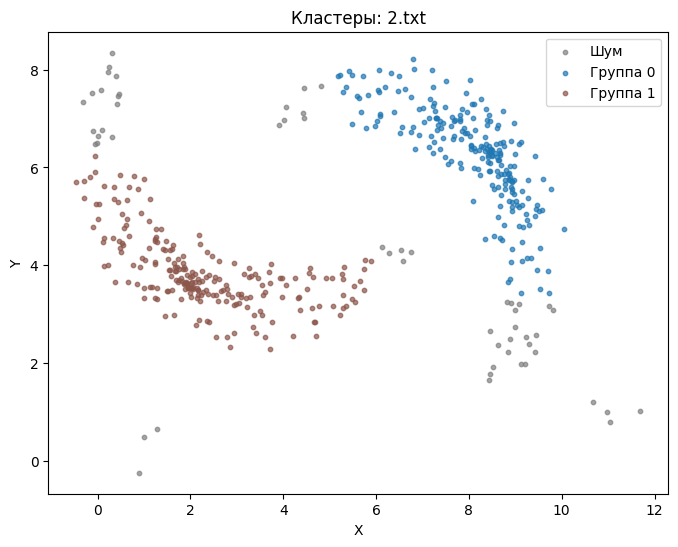

Кластер 0: медоид = [8.22687968 6.35738211]
Кластер 1: медоид = [2.09088854 3.66325727]
Среднее центроидов * 100000 → X=517837, Y=505421

Файл: 3.txt
Количество кластеров: 3
Количество шумовых точек: 12


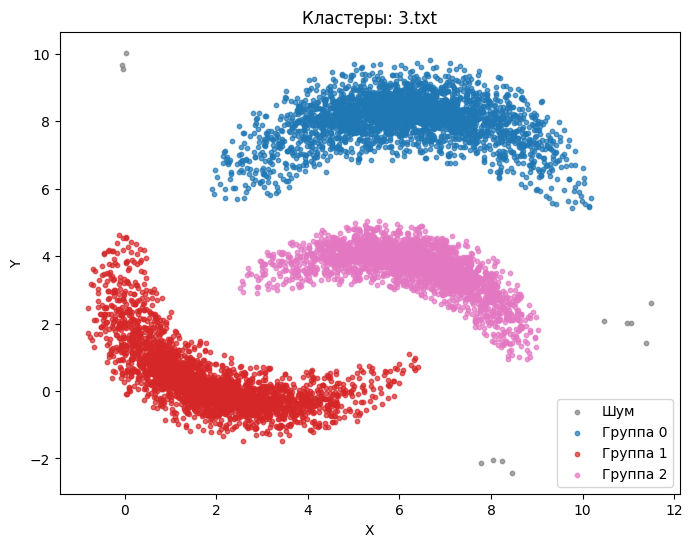

Кластер 0: медоид = [6.09727603 8.29044994]
Кластер 1: медоид = [1.69615102 0.12926251]
Кластер 2: медоид = [6.33889118 3.85633299]
Среднее центроидов * 100000 → X=472968, Y=404287

Файл: 4.txt
Количество кластеров: 2
Количество шумовых точек: 16


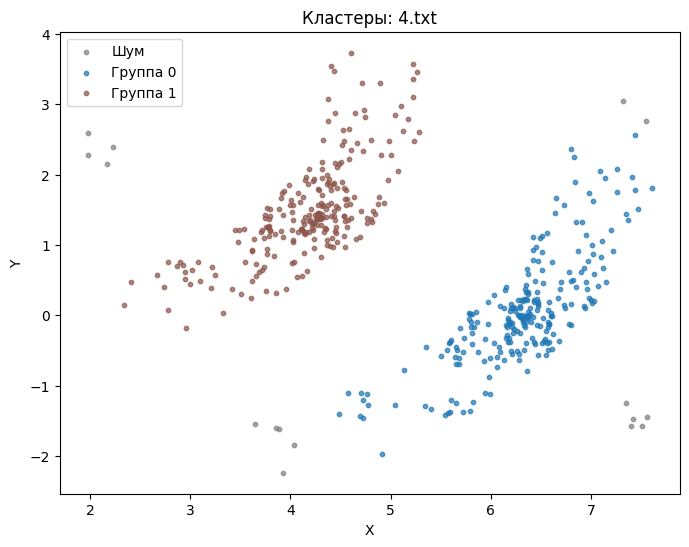

Кластер 0: медоид = [ 6.34537950e+00 -6.18192182e-03]
Кластер 1: медоид = [4.24476995 1.43145812]
Среднее центроидов * 100000 → X=524576, Y=77416

Файл: 5.txt
Количество кластеров: 3
Количество шумовых точек: 12


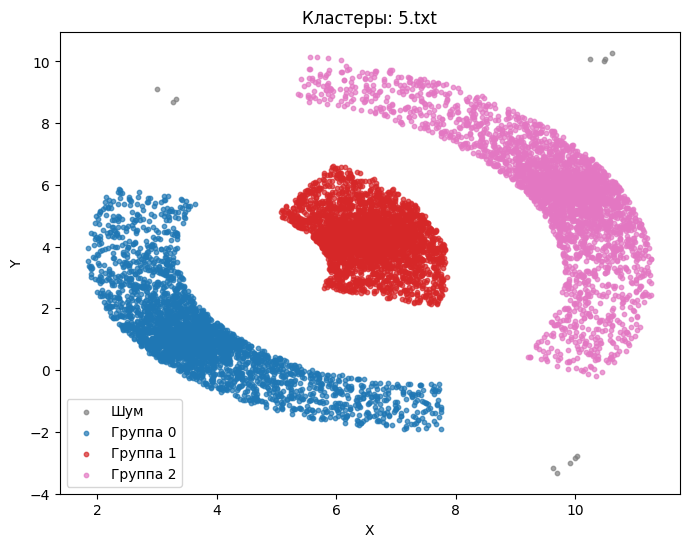

Кластер 0: медоид = [3.58369201 0.99978374]
Кластер 1: медоид = [6.63243918 4.2921765 ]
Кластер 2: медоид = [9.88226828 5.82908407]
Среднее центроидов * 100000 → X=667033, Y=369098

Итоговые значения:
0.xls: 44399, -51244
1.xls: 124659, 24805
2.txt: 517837, 505421
3.txt: 472968, 404287
4.txt: 524576, 77416
5.txt: 667033, 369098


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque


# --- Расстояние между двумя точками ---
def dist_l2(p1, p2):
    diff = p1 - p2
    return np.sqrt(np.dot(diff, diff))


# --- Реализация DBSCAN ---
def run_dbscan(data, radius=1.0, min_pts=30):
    total = data.shape[0]
    marks = np.full(total, -1)
    was_seen = np.zeros(total, dtype=bool)
    current_cluster = 0

    def find_neighbors(idx):
        base_point = data[idx]
        return [
            j for j in range(total)
            if dist_l2(base_point, data[j]) <= radius
        ]

    for idx in range(total):
        if was_seen[idx]:
            continue

        was_seen[idx] = True
        nearby = find_neighbors(idx)

        if len(nearby) < min_pts:
            marks[idx] = -1
            continue

        marks[idx] = current_cluster
        queue = deque(nearby)

        while queue:
            candidate = queue.popleft()

            if not was_seen[candidate]:
                was_seen[candidate] = True
                candidate_neighbors = find_neighbors(candidate)
                if len(candidate_neighbors) >= min_pts:
                    queue.extend(candidate_neighbors)

            if marks[candidate] == -1:
                marks[candidate] = current_cluster

        current_cluster += 1

    return marks


# --- Загрузка данных ---
def load_xy(path):
    if path.lower().endswith('.xls'):
        table = pd.read_excel(path)
    else:
        table = pd.read_csv(path)

    if list(table.columns[:2]) == ['X', 'Y']:
        coords = table[['X', 'Y']]
    else:
        coords = table.iloc[:, :2]

    return coords.to_numpy(dtype=float)


# --- Поиск медоида ---
def find_medoid(points_array):
    pairwise = np.sqrt(
        ((points_array[:, None] - points_array[None, :]) ** 2).sum(axis=2)
    )
    total_dist = pairwise.sum(axis=1)
    return np.argmin(total_dist)


# --- Основной блок ---
dataset_files = ['0.xls', '1.xls', '2.txt', '3.txt', '4.txt', '5.txt']
summary_output = []

for file_name in dataset_files:
    print(f"\nФайл: {file_name}")

    coords = load_xy(file_name)
    cluster_labels = run_dbscan(coords, radius=1.0, min_pts=30)

    unique_ids = np.unique(cluster_labels)
    cluster_count = len(unique_ids[unique_ids != -1])
    noise_count = np.sum(cluster_labels == -1)

    print(f"Количество кластеров: {cluster_count}")
    print(f"Количество шумовых точек: {noise_count}")

    # --- Визуализация ---
    plt.figure(figsize=(8, 6))
    palette = plt.cm.tab10(np.linspace(0, 1, cluster_count + 1))

    for cid in unique_ids:
        mask = cluster_labels == cid

        if cid == -1:
            color = 'gray'
            label = 'Шум'
        else:
            color = palette[cid % len(palette)]
            label = f'Группа {cid}'

        plt.scatter(
            coords[mask, 0],
            coords[mask, 1],
            c=[color],
            s=10,
            alpha=0.7,
            label=label
        )

    plt.title(f'Кластеры: {file_name}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

    # --- Медоиды ---
    for cid in range(cluster_count):
        cluster_points = coords[cluster_labels == cid]
        center_idx = find_medoid(cluster_points)
        center_point = cluster_points[center_idx]
        print(f"Кластер {cid}: медоид = {center_point}")

    # --- Среднее центроидов ---
    centroids = [
        coords[cluster_labels == cid].mean(axis=0)
        for cid in range(cluster_count)
    ]

    if centroids:
        avg_center = np.mean(np.vstack(centroids), axis=0)
        scaled_x = int(avg_center[0] * 100000)
        scaled_y = int(avg_center[1] * 100000)

        summary_output.append((file_name, scaled_x, scaled_y))

        print(f"Среднее центроидов * 100000 → X={scaled_x}, Y={scaled_y}")
    else:
        print("Кластеры не найдены.")

print("\nИтоговые значения:")
for name, x_val, y_val in summary_output:
    print(f"{name}: {x_val}, {y_val}")

In [4]:
pip install xlrd


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\lobod\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Кластеризация (1 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [15]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

warnings.filterwarnings("ignore")

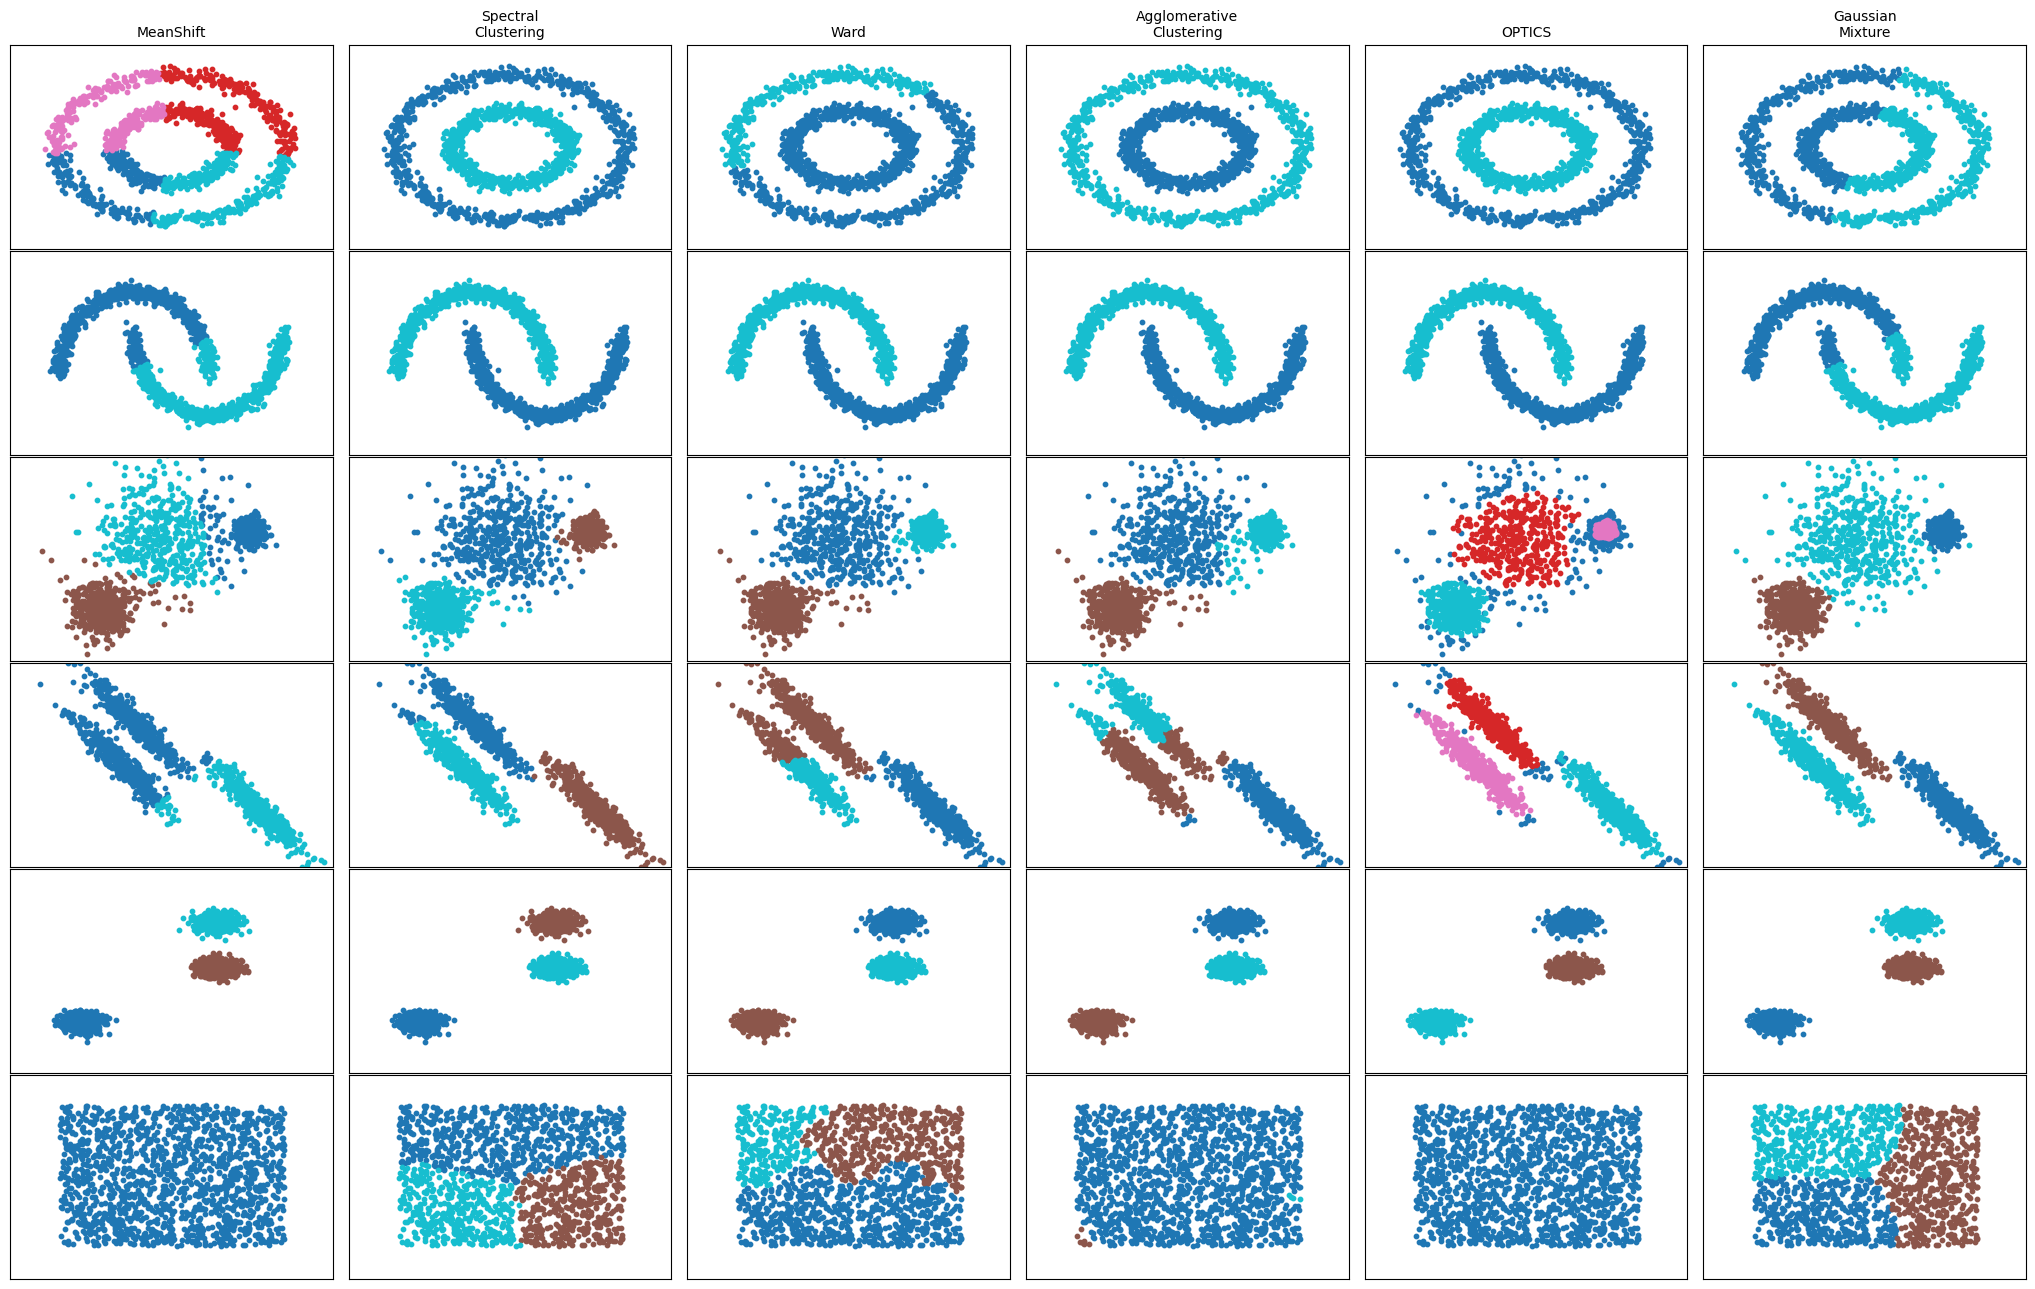

In [16]:
# =========================
# Инициализация алгоритмов
# =========================

two_means = cluster.KMeans(
    n_clusters=2,
    n_init="auto",
    random_state=0
)

dbscan = cluster.DBSCAN(
    eps=0.3,
    min_samples=5
)

ms = cluster.MeanShift()

spectral = cluster.SpectralClustering(
    n_clusters=3,
    affinity="nearest_neighbors",
    assign_labels="kmeans",
    random_state=0
)

ward = cluster.AgglomerativeClustering(
    n_clusters=3,
    linkage="ward"
)

average_linkage = cluster.AgglomerativeClustering(
    n_clusters=3,
    linkage="average"
)

optics = cluster.OPTICS(
    min_samples=20,
    xi=0.05,
    min_cluster_size=0.1
)

gmm = mixture.GaussianMixture(
    n_components=3,
    covariance_type="full",
    random_state=0
)

clustering_algorithms = (
    ("MeanShift", ms),
    ("Spectral\nClustering", spectral),
    ("Ward", ward),
    ("Agglomerative\nClustering", average_linkage),
    ("OPTICS", optics),
    ("Gaussian\nMixture", gmm),
)

# =========================
# Генерация данных
# =========================

np.random.seed(0)

n_samples = 1500

noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05
)
noisy_moons = datasets.make_moons(
    n_samples=n_samples, noise=0.05
)
blobs = datasets.make_blobs(
    n_samples=n_samples, random_state=8
)
no_structure = np.random.rand(n_samples, 2), None

random_state = 170
X, y = datasets.make_blobs(
    n_samples=n_samples, random_state=random_state
)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(
    n_samples=n_samples,
    cluster_std=[1.0, 2.5, 0.5],
    random_state=random_state
)

# =========================
# Настройка визуализации
# =========================

plt.figure(figsize=(21, 13))
plt.subplots_adjust(
    left=0.02, right=0.98,
    bottom=0.001, top=0.95,
    wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

dataset_list = [
    (
        noisy_circles,
        {
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

# =========================
# Основной цикл
# =========================

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):

    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    X = StandardScaler().fit_transform(X)

    bandwidth = cluster.estimate_bandwidth(
        X, quantile=params["quantile"]
    )

    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    connectivity = 0.5 * (connectivity + connectivity.T)

    for name, algorithm in clustering_algorithms:

        t0 = time.time()

        if name == "MeanShift":
            algorithm.set_params(bandwidth=bandwidth)

        elif name == "Spectral\nClustering":
            algorithm.set_params(n_clusters=params["n_clusters"])

        elif name in ("Ward", "Agglomerative\nClustering"):
            algorithm.set_params(
                n_clusters=params["n_clusters"],
                connectivity=connectivity
            )

        elif name == "OPTICS":
            algorithm.set_params(
                min_samples=params["min_samples"],
                xi=params["xi"],
                min_cluster_size=params["min_cluster_size"]
            )

        elif name == "Gaussian\nMixture":
            algorithm.set_params(
                n_components=params["n_clusters"]
            )

        algorithm.fit(X)

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(
            len(dataset_list),
            len(clustering_algorithms),
            plot_num
        )

        if i_dataset == 0:
            plt.title(name, fontsize=10)

        unique_labels = np.unique(y_pred)
        colors = plt.cm.tab10(
            np.linspace(0, 1, len(unique_labels))
        )

        for k, col in zip(unique_labels, colors):
            mask = y_pred == k
            plt.scatter(
                X[mask, 0],
                X[mask, 1],
                s=10,
                color=col
            )

        plt.xticks(())
        plt.yticks(())
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)

        plot_num += 1

plt.show()